<a href="https://colab.research.google.com/github/johnhallman/ctsb/blob/tutorials/tutorials/notebooks/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Models: Pre-implemented Algorithms for Solving Problems


In [0]:
!git clone https://github.com/johnhallman/ctsb.git
!pip install -e ctsb[all]

In [0]:
import ctsb
import jax.numpy as np
import matplotlib.pyplot as plt

The Model class is the abstraction used to implement models/predictors for the problems. CTSB is designed so that the Model and Problem classes can be combined in a modular fashion. Roughly speaking, the goal of CTSB is to be able to test an arbitrary model on an arbitrary problem, at least when it makes sense to do so. The initialize method sets up the model with  given hyperparameters. The predict method returns the prediction for a given input. The update method updates the parameters of the model according to an optimizer, which is either stored as an attribute of the model or implemented manually in certain cases.



# Time Series Models
For example, below we show how to combine a basic last-value model (a predictor that just outputs the previous observation) for time-series on the ARMA problem.

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


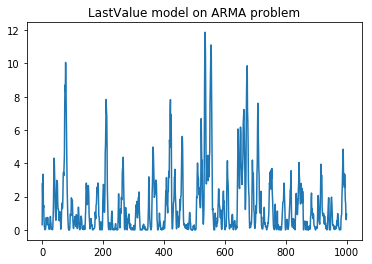

test_last_value passed


In [0]:
from ctsb.models.optimizers.losses import mse

T = 1000 
p, q = 3, 3
problem = ctsb.problem("ARMA-v0")
cur_x = problem.initialize(p, q)

model = ctsb.model("LastValue")
model.initialize()

results = []
for i in range(T):
  cur_y_pred = model.predict(cur_x)
  cur_y_true = problem.step()
  cur_loss = mse(cur_y_true, cur_y_pred)
  results.append(cur_loss)
  model.update(cur_y_true)
  cur_x = cur_y_true

plt.plot(results)
plt.title("LastValue model on ARMA problem")
plt.show()

#Control Models
Next, we demonstrate the classical Kalman filter on a trivial dynamical system where the observation has constant value.

/usr/local/lib/python3.6/dist-packages/jax/numpy/linalg.py:119: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)
/usr/local/lib/python3.6/dist-packages/jax/numpy/linalg.py:211: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)


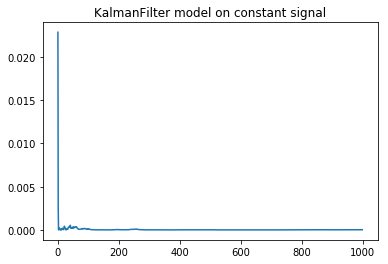

test_kalman_filter passed


In [0]:
import jax.random as random
from ctsb.utils import generate_key

T = steps 
x_true = 0.5
env_noise = 0.1
x0 = 0

model = ctsb.model("KalmanFilter")
model.initialize(x0, 1, 0, 1, 1, 0, env_noise)

results = []
for i in range(T):
  z = x_true + float(random.normal(generate_key(), shape = (1,)) * env_noise)
  x_pred = model.step(0, z)
  cur_loss = mse(x_true, x_pred)
  results.append(cur_loss)

plt.plot(results)
plt.title("KalmanFilter model on constant signal")
plt.show()

#PyBullet Models
PyBullet contains a unique class of problems which require installation of the full CTSB framework (ex. via pip install -e ctsb[all]) and tend to be much more challenging than regular control problems. Below we demonstrate a pretrained neural network policy running on CartPoleSwingup.

In [0]:
model = ctsb.model("CartPoleNN")
model.initialize(problem.get_observation_space(), problem.get_action_space())

problem = ctsb.problem("CartPoleSwingup-v0")
obs = problem.initialize(render=True)

while 1:
  a = model.predict(obs)
  obs, r, done, _ = problem.step(a)
  if done:
    break